# Predict #
To be re-inserted into main Jupyter Notebook after.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# For neural networks.
import keras as kr
# For data frames.
import pandas as pd
# For numerical arrays.
import numpy as np
# For preprocessing data.
import sklearn.preprocessing as pre
# For splitting data sets.
import sklearn.model_selection as mod
# For whitening.
import sklearn.decomposition as dec
# to write to csv file
import csv

Using TensorFlow backend.


In [2]:
# Import sklearn for comparison too
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [3]:
# Load the dataset into a dataframe
data = pd.DataFrame(data = load_boston().data, columns= load_boston().feature_names)
# Add the house price
data["MEDV"] = load_boston().target
# Quick check that all is ok
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


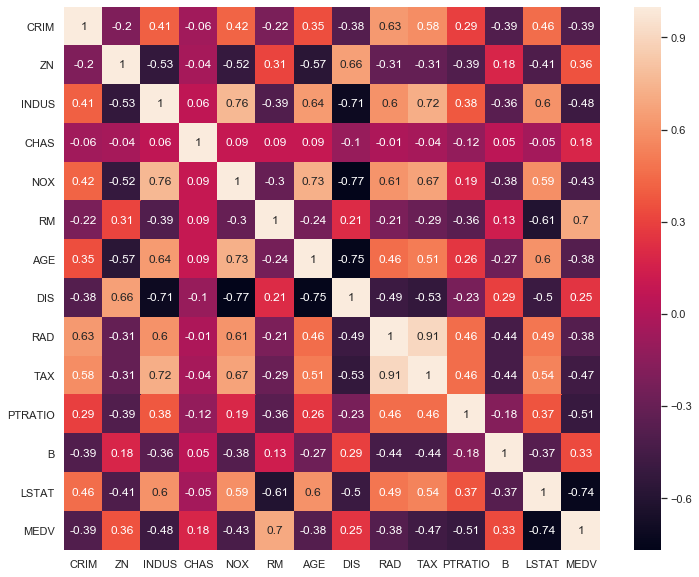

In [4]:
sns.set(rc={'figure.figsize':(12,10)})
correlation_matrix = data.corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)

In [5]:
correlation_matrix["MEDV"]

CRIM      -0.39
ZN         0.36
INDUS     -0.48
CHAS       0.18
NOX       -0.43
RM         0.70
AGE       -0.38
DIS        0.25
RAD       -0.38
TAX       -0.47
PTRATIO   -0.51
B          0.33
LSTAT     -0.74
MEDV       1.00
Name: MEDV, dtype: float64

In [6]:
cm = correlation_matrix.transform(func= lambda x: abs(x))["MEDV"].sort_values(ascending=False)
cm = cm.drop("MEDV",axis=0)
cm

LSTAT      0.74
RM         0.70
PTRATIO    0.51
INDUS      0.48
TAX        0.47
NOX        0.43
CRIM       0.39
RAD        0.38
AGE        0.38
ZN         0.36
B          0.33
DIS        0.25
CHAS       0.18
Name: MEDV, dtype: float64

In [7]:
# Putting all possible parameters in a list in order of correlation
params = []
for i in range(0, len(cm)):
    params.append(cm.index[i])

In [8]:
y = data['MEDV'] # outputs

def getInputs(noPar):
    # Split the dataset into what we are using
    return data[params[:noPar]] # inputs

In [9]:
def scaleDS(inputs):
    # Adding a scaler
    scaler = pre.StandardScaler()
    scaler.fit(inputs)
    return scaler.transform(inputs)

In [10]:
def whiten(noAttrib, inputs):
    # Pre-component Analysis
    pca = dec.PCA(n_components=noAttrib, whiten=True)
    pca.fit(inputs)
    # Whiten the dataset
    inputs_train_white = pd.DataFrame(pca.transform(inputs), columns=inputs.columns)
    return inputs_train_white

In [11]:
def splitDS(inputs):
    global x_train, x_test, y_train, y_test
    # Split the dataset into training and testing
    x_train, x_test, y_train, y_test = mod.train_test_split(inputs, y, test_size=testSize)

In [12]:
def createModel(actType, optType):
    global noParams, noEpoch, batchSize
    # Create our model
    m = kr.models.Sequential()
    m.add(kr.layers.Dense(20, input_dim=noParams, activation = actType))
    m.add(kr.layers.Dense(1, activation="linear"))
    m.compile(loss = "mean_squared_error", optimizer =optType)
    # Train the network
    m.fit(x_train, y_train, epochs=noEpoch, batch_size=batchSize)
    return m

In [13]:
def doModel(model, epo, bs):
    global x_trian, x_test, y_tran, y_test, batchSize
    # Train the network
    model.fit(x_train, y_train, epochs=epo, batch_size=bs)
    # Calculate the loss function (Mean squared error in our case)
    return model.evaluate(x_test, y_test)

In [14]:
# Headings for the data
results= []

In [15]:
# Parameterise everything

# Do you want to create and test all the models? 
# If yes, set the following to true, if no, leave at false and data from previous run will be read into dataframe
yesCreateModels = False

# No of variables to include in predictions
noParams = 4 

# Test / Train Split
testSize = 0.3

# All the activations
acts = ["relu", "tanh", "sigmoid", "exponential", "elu", "linear"]
#act = acts[5]


# model trial settings
# Optimisers
opts= ["sgd", "adam", "nadam"]
opt = opts[2]
noEpoch= 100
batchSize = 10

# Whether the data should be scaled or not
pre_process = "whitened" # Pre-processing: raw, scaled or whitened 

if yesCreateModels == True:
    results= []
    # Check for increasing no of attributes and all activations
    for act in acts:
        for noParams in range(1,13):
            print("Starting", act, "Parameter no:",noParams)
            # Create your inputs
            x = getInputs(noParams)
            # Scale if it is called for
            if pre_process  == "scaled":
                x_scaled = scaleDS(x)
            elif pre_process == "raw":
                x_scaled = x
            elif pre_process == "whitened":
                x_scaled = whiten(noParams, x)
            # Split into training and testing data
            splitDS(x_scaled)
            # Create the model based on the paramters supplied
            m = createModel(act, opt)
            # Append the settings and final loss results after fitting and evaluating the model to the results file
            results.append([noParams, pre_process, testSize, act, opt, noEpoch, batchSize, doModel(m, noEpoch, batchSize)])

In [16]:
# Transfer all the data to a dataframe
if yesCreateModels == True:
    csvWriteType = "a" # "a" for append to add to existing csv, "w" to overwrite existing csv
    # Create a dataframe with the results and save it to a csv file if you don't want to go through the model generation in future
    columns = ["no_attrib", "pre_process", "test_size", "activation", "optimiser", "no_epochs", "batch_size", "loss"]
    tempdf = pd.DataFrame(results, columns=columns)
    tempdf.to_csv (r'data\results.csv', mode =csvWriteType, index = None, header=(csvWriteType == "w"), sep =",")

In [17]:
# If you didn't want to do the generation, read the csv file already prepared anyway
df = pd.read_csv(r"data\results.csv", error_bad_lines=False)

In [18]:
#df.isnull()
drop_rows = df.index[df.no_attrib== "False"]
nan_rows = df.index[df["loss"].isnull()]
df.drop(drop_rows, axis=0, inplace=True)
df.drop(nan_rows, axis=0, inplace=True)

C:\Users\ybrady\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [19]:
df.pre_process.value_counts()

whitened    613
scaled      612
raw         506
Name: pre_process, dtype: int64

In [20]:
# Sort the various model iterations according to loss to determine the best model(s) to chose) 
df.sort_values(by='loss', ascending=True)

,no_attrib,pre_process,test_size,activation,optimiser,no_epochs,batch_size,loss
1929,10,whitened,0.3,elu,nadam,100,10,6.746766e+00
467,12,whitened,0.3,sigmoid,sgd,100,10,7.593348e+00
633,10,whitened,0.3,elu,nadam,100,10,7.795660e+00
251,12,scaled,0.3,sigmoid,sgd,100,10,8.372111e+00
1591,8,scaled,0.3,relu,adam,100,10,8.421454e+00
1845,10,whitened,0.3,exponential,adam,100,10,8.561158e+00
1015,8,scaled,0.3,relu,nadam,100,10,8.602223e+00
1063,8,scaled,0.3,elu,nadam,100,10,8.641912e+00
1763,12,whitened,0.3,sigmoid,sgd,100,10,8.704313e+00
249,10,scaled,0.3,sigmoid,sgd,100,10,8.745815e+00


In [21]:
df[["no_attrib", "pre_process", "activation", "optimiser", "loss"]].groupby(["no_attrib", "pre_process", "activation", "optimiser"]).mean().sort_values(by='loss', ascending=True)

,,,,loss
no_attrib,pre_process,activation,optimiser,
12,whitened,sigmoid,sgd,9.002994e+00
10,whitened,elu,nadam,9.418344e+00
8,whitened,relu,nadam,1.070377e+01
9,scaled,relu,nadam,1.082897e+01
7,scaled,tanh,nadam,1.097046e+01
9,whitened,sigmoid,sgd,1.105663e+01
10,whitened,relu,nadam,1.112411e+01
9,scaled,elu,adam,1.120305e+01
7,whitened,sigmoid,sgd,1.124261e+01


Text(0.5, 0.9, 'Performance of Different Activations Using Various Number of Attributes')

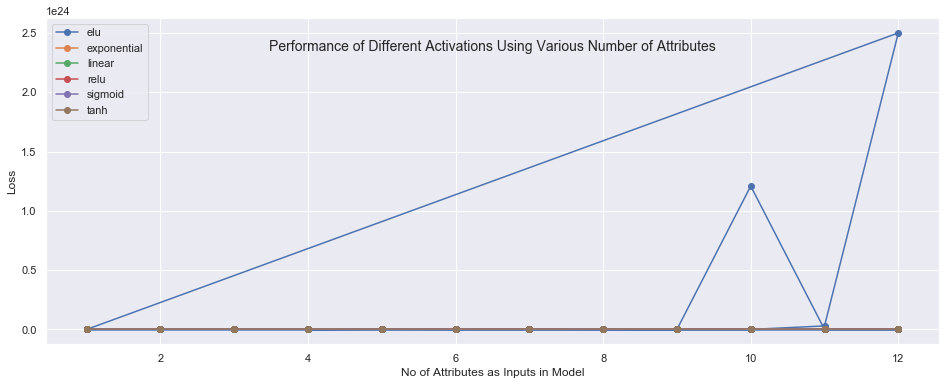

In [22]:
# Plot the actvations to see which performed best
plt.rcParams["figure.figsize"] = [16, 6]
groups = df.groupby(["activation"])

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for activation, group in groups:
    ax.plot(group["no_attrib"], group["loss"], marker='.', linestyle='-', ms=12, label=activation)
ax.legend()
ax.set_ylabel("Loss")
ax.set_xlabel("No of Attributes as Inputs in Model")
ax.text(.5,.9,"Performance of Different Activations Using Various Number of Attributes", horizontalalignment='center',transform=ax.transAxes,fontsize=14)

Text(0.5, 0.9, 'Performance of Different Optimiser Using Various Number of Attributes')

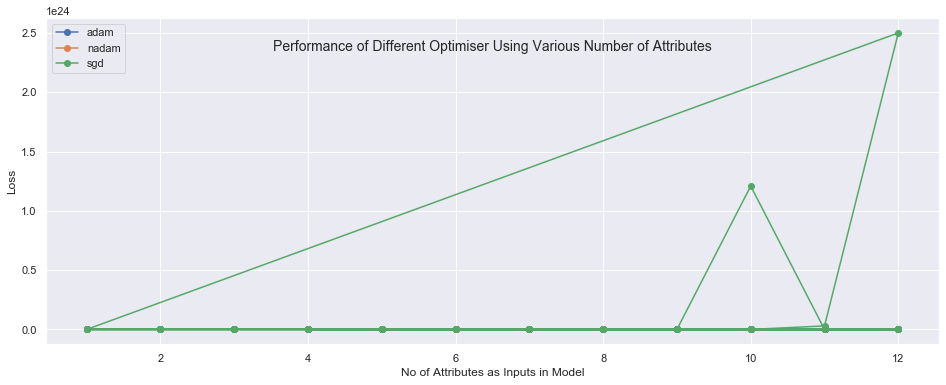

In [23]:
# Plot the actvations to see which performed best
plt.rcParams["figure.figsize"] = [16, 6]
groups = df.groupby('optimiser')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for optimiser, group in groups:
    ax.plot(group["no_attrib"], group["loss"], marker='.', linestyle='-', ms=12, label=optimiser)
ax.legend()
ax.set_ylabel("Loss")
ax.set_xlabel("No of Attributes as Inputs in Model")
ax.text(.5,.9,"Performance of Different Optimiser Using Various Number of Attributes", horizontalalignment='center',transform=ax.transAxes,fontsize=14)

In [24]:
# Sort the various model iterations according to loss to determine the best model(s) to chose) 
df.sort_values(by='loss', ascending=True)

,no_attrib,pre_process,test_size,activation,optimiser,no_epochs,batch_size,loss
1929,10,whitened,0.3,elu,nadam,100,10,6.746766e+00
467,12,whitened,0.3,sigmoid,sgd,100,10,7.593348e+00
633,10,whitened,0.3,elu,nadam,100,10,7.795660e+00
251,12,scaled,0.3,sigmoid,sgd,100,10,8.372111e+00
1591,8,scaled,0.3,relu,adam,100,10,8.421454e+00
1845,10,whitened,0.3,exponential,adam,100,10,8.561158e+00
1015,8,scaled,0.3,relu,nadam,100,10,8.602223e+00
1063,8,scaled,0.3,elu,nadam,100,10,8.641912e+00
1763,12,whitened,0.3,sigmoid,sgd,100,10,8.704313e+00
249,10,scaled,0.3,sigmoid,sgd,100,10,8.745815e+00
